In [1]:
import numpy as np
import pandas as pd #to read files or work with dataframes
import yfinance as yf
import datetime as datetime #to specify start and end dates
import matplotlib.pyplot as plt #to visualize
from matplotlib import style
import pandas_datareader as dr #to collect data
from pandas_datareader import data
import cvxpy as cp
import cvxopt as opt
from cvxopt import blas, solvers
import scipy.optimize as sco

%matplotlib inline

In [2]:
#Parameter set up:
n_portfolios = 5000
n_days = 252
assets = ['AHT.L', 'PFD.L', 'ENT.L', 'SMT.L', 'AVV.L', 'SPX.L', 'LUCE.L', 'DPLM.L', 'GSK.L', 'BP.L', 'SCT.L', 'BLND.L', 'MGGT.L', 'FUTR.L', 'CRDA.L', 'AAF.L', 'WOSG.L', 'KAPE.L', 'INDV.L', 'FAN.L', 'NFC.L', 'SAFE.L', 'MMH.L', 'CWR.L', 'XTR.L', 'BEZ.L', 'JD.L', 'NANO.L', 'BARC.L', 'AEP.L', 'GTLY.L', 'BIFF.L']
assets.sort()
start_date = '2020-01-01'
end_date = '2022-04-25'

n_assets = len(assets)

In [3]:
#Downloading stockprices from Yahoo Finance:
prices = yf.download(assets, start=start_date, end=end_date, adjusted=True)

[*********************100%***********************]  32 of 32 completed


In [4]:
#Calculation of Annualised Average Returns and the corresponding Standard Deviation:
returns = prices['Adj Close'].pct_change().dropna()
returns

,AAF.L,AEP.L,AHT.L,AVV.L,BARC.L,BEZ.L,BIFF.L,BLND.L,BP.L,CRDA.L,...,MMH.L,NANO.L,NFC.L,PFD.L,SAFE.L,SCT.L,SMT.L,SPX.L,WOSG.L,XTR.L
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-03,-0.003807,-0.032258,-0.006250,-0.004243,-0.010259,-0.010610,-0.003711,0.002547,0.027451,-0.002941,...,0.003247,0.007394,0.015038,-0.002628,-0.003077,-0.011686,0.000853,-0.002212,0.000000,0.000000
2020-01-06,-0.000637,0.035088,0.007967,-0.003835,-0.012657,-0.023235,-0.024209,-0.023500,0.020342,0.001966,...,0.000000,0.012844,0.003704,0.001318,-0.013580,-0.025338,-0.009378,-0.006652,-0.037436,0.000000
2020-01-07,0.010835,-0.022034,-0.002496,0.010265,0.011935,-0.000915,-0.009542,0.005854,-0.010514,-0.000981,...,0.000000,-0.057971,-0.003690,-0.019737,-0.012516,0.016465,0.010327,-0.001116,0.022376,0.000000
2020-01-08,-0.019546,-0.020797,0.012093,0.006774,-0.006006,-0.012820,0.013487,-0.025541,-0.009022,0.000000,...,0.000000,0.000000,0.000000,-0.006711,-0.012674,-0.013640,0.005111,0.000000,-0.022929,0.025641
2020-01-09,-0.001929,0.000000,0.018954,0.006645,0.004505,0.010204,-0.009506,-0.016921,-0.004552,-0.010806,...,0.000000,-0.007692,0.000000,-0.009459,-0.007060,-0.006050,0.017797,-0.002235,0.013333,0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-14,-0.004692,0.002227,-0.002832,-0.010242,0.011091,0.000495,0.007299,0.006180,0.005285,0.004763,...,-0.012658,0.046205,0.014129,0.001669,0.018954,0.002004,-0.005203,0.009608,0.022302,0.037313
2022-04-19,0.006061,0.028889,0.003058,0.002070,-0.001097,-0.025743,0.024155,-0.016507,0.004005,-0.023176,...,0.010256,0.012618,0.013932,-0.028333,-0.017113,-0.002000,-0.016946,-0.011499,-0.016579,-0.035971
2022-04-20,-0.011379,0.000000,0.040070,0.015696,0.021826,0.028963,-0.007665,-0.000390,0.000249,0.017525,...,0.000000,0.015576,0.035115,0.000000,-0.001514,0.006012,-0.005320,0.012034,0.036380,0.000000


In [5]:
avg_returns = returns.mean()* n_days
avg_returns

AAF.L     0.502473
AEP.L     0.232062
AHT.L     0.392154
AVV.L    -0.083242
BARC.L    0.041712
BEZ.L    -0.035213
BIFF.L    0.168540
BLND.L    0.024734
BP.L      0.075509
CRDA.L    0.222704
CWR.L     0.671334
DPLM.L    0.224459
ENT.L     0.369359
FAN.L     0.352757
FUTR.L    0.399367
GSK.L     0.070394
GTLY.L    0.122673
INDV.L    1.099739
JD.L      0.071269
KAPE.L    0.445272
LUCE.L    0.417531
MGGT.L    0.310792
MMH.L     0.529271
NANO.L    0.749863
NFC.L     0.546104
PFD.L     0.593442
SAFE.L    0.282576
SCT.L     0.163240
SMT.L     0.265502
SPX.L     0.189947
WOSG.L    0.613256
XTR.L     1.437952
dtype: float64

In [6]:
cov_mat = returns.cov() * n_days
cov_mat

,AAF.L,AEP.L,AHT.L,AVV.L,BARC.L,BEZ.L,BIFF.L,BLND.L,BP.L,CRDA.L,...,MMH.L,NANO.L,NFC.L,PFD.L,SAFE.L,SCT.L,SMT.L,SPX.L,WOSG.L,XTR.L
AAF.L,0.402347,0.082129,0.102577,0.076474,0.120800,0.102742,0.031672,0.073685,0.116289,0.035865,...,0.028628,0.068408,0.032041,0.065498,0.056903,0.040684,0.072417,0.034210,0.074143,0.044887
AEP.L,0.082129,0.191429,0.036588,0.033121,0.056746,0.039721,0.015515,0.031351,0.055426,0.017189,...,0.007896,0.033159,0.042817,0.024676,0.024773,0.016307,0.032972,0.017066,0.020886,0.019702
AHT.L,0.102577,0.036588,0.190891,0.077905,0.117332,0.061958,0.037075,0.073393,0.094156,0.047312,...,0.019282,0.053185,0.062661,0.038621,0.053597,0.048778,0.096956,0.061785,0.075120,0.039405
AVV.L,0.076474,0.033121,0.077905,0.161465,0.060001,0.046137,0.036813,0.039701,0.051459,0.042294,...,0.012503,0.078156,0.044299,0.032717,0.040590,0.063220,0.091364,0.052779,0.062100,0.037115
BARC.L,0.120800,0.056746,0.117332,0.060001,0.218743,0.096746,0.050840,0.124004,0.134251,0.021478,...,0.022017,0.058010,0.065146,0.045383,0.054732,0.038202,0.070385,0.034722,0.097303,0.052535
BEZ.L,0.102742,0.039721,0.061958,0.046137,0.096746,0.181032,0.025851,0.081650,0.066523,0.019668,...,0.018231,0.054215,0.034150,0.026654,0.047793,0.037845,0.055559,0.031781,0.069854,0.009550
BIFF.L,0.031672,0.015515,0.037075,0.036813,0.050840,0.025851,0.139630,0.043306,0.027455,0.026781,...,0.008027,0.008494,0.018956,0.014753,0.016307,0.025687,0.037610,0.029910,0.039520,0.014237
BLND.L,0.073685,0.031351,0.073393,0.039701,0.124004,0.081650,0.043306,0.159352,0.090556,0.014713,...,0.014226,0.026249,0.045678,0.025104,0.052871,0.029049,0.044383,0.026890,0.087076,0.016767
BP.L,0.116289,0.055426,0.094156,0.051459,0.134251,0.066523,0.027455,0.090556,0.207837,0.014344,...,0.014404,0.043939,0.054536,0.041102,0.034228,0.032345,0.056341,0.031206,0.060080,0.032622
CRDA.L,0.035865,0.017189,0.047312,0.042294,0.021478,0.019668,0.026781,0.014713,0.014344,0.068704,...,0.005976,0.025154,0.021925,0.012136,0.022803,0.031270,0.047496,0.039861,0.016503,0.006274


In [7]:
prices = pd.DataFrame()
for tick in assets:
    prices[tick] = data.DataReader(tick, data_source='yahoo', start='2020-01-01', end='2022-04-25')['Adj Close']
prices.columns = assets
    
prices

,AAF.L,AEP.L,AHT.L,AVV.L,BARC.L,BEZ.L,BIFF.L,BLND.L,BP.L,CRDA.L,...,MMH.L,NANO.L,NFC.L,PFD.L,SAFE.L,SCT.L,SMT.L,SPX.L,WOSG.L,XTR.L
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,71.557549,587.905151,2341.296387,3688.335205,171.548996,542.869873,267.862152,584.757996,414.027313,4910.428223,...,140.276184,13.525000,526.575134,37.702827,765.369080,1167.235962,582.167419,8824.490234,390.000000,0.975
2020-01-03,71.285118,568.940430,2326.663086,3672.687012,169.789062,537.109985,266.868225,586.247253,425.392822,4895.985352,...,140.731628,13.625000,534.493530,37.603741,763.014099,1153.595581,582.664124,8804.967773,390.000000,0.975
2020-01-06,71.239716,588.903320,2345.198486,3658.603516,167.640045,524.630249,260.407745,572.470825,434.046265,4905.613770,...,140.731628,13.800000,536.473145,37.653286,752.652161,1124.365845,577.200134,8746.398438,375.399994,0.975
2020-01-07,72.011589,575.927490,2339.344727,3696.159668,169.640854,524.150269,257.922943,575.821899,429.482819,4900.800293,...,140.731628,13.000000,534.493530,36.910126,743.232239,1142.877930,583.160889,8736.636719,383.799988,0.975
2020-01-08,70.604050,563.949768,2367.635742,3721.197266,168.621933,517.430359,261.401672,561.114441,425.608124,4900.800293,...,140.731628,13.000000,534.493530,36.662407,733.812317,1127.288818,586.141174,8736.636719,375.000000,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-19,149.399994,926.000000,4592.000000,2421.000000,145.699997,393.600006,339.200012,512.400024,395.835083,7362.147461,...,394.000000,32.099998,1310.000000,116.599998,1321.000000,1497.000000,939.799988,12465.000000,1127.000000,6.700
2022-04-20,147.699997,926.000000,4776.000000,2459.000000,148.880005,405.000000,336.600006,512.200012,395.933807,7491.168945,...,394.000000,32.599998,1356.000000,116.599998,1319.000000,1506.000000,934.799988,12615.000000,1168.000000,6.700
2022-04-21,146.600006,902.000000,4817.000000,2521.000000,150.059998,414.000000,339.399994,524.200012,397.907776,7620.189941,...,394.000000,32.500000,1364.000000,115.400002,1324.000000,1504.000000,932.000000,12720.000000,1159.000000,6.600


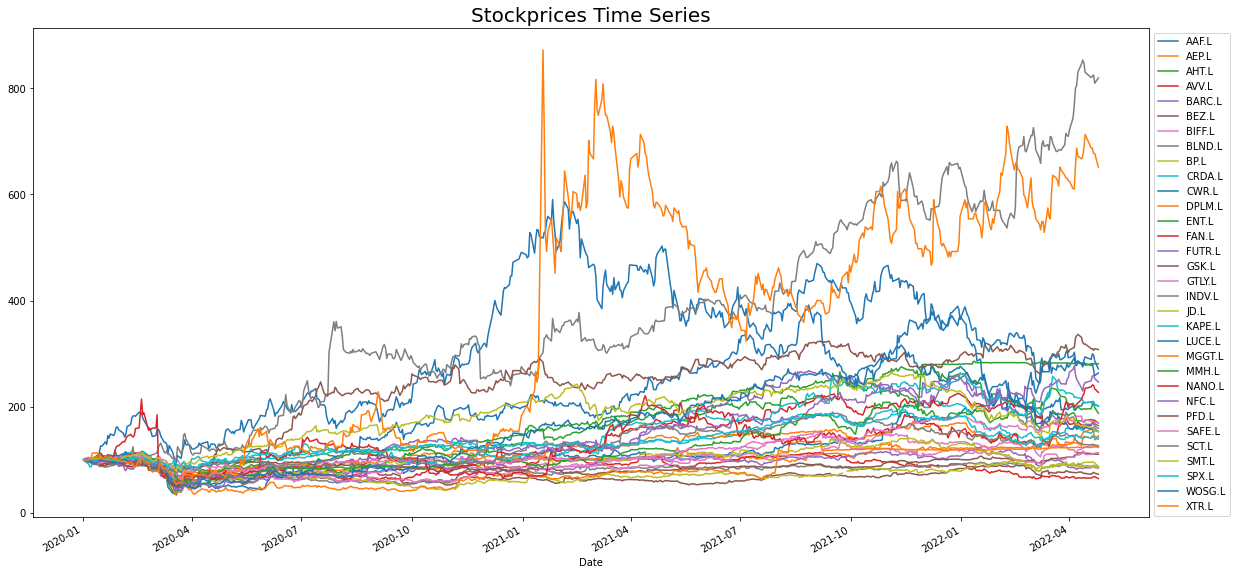

In [8]:
# Plotting the timeseries:
timeseries = prices / prices.iloc[0] * 100
timeseries.plot(figsize=(20, 10))
plt.title('Stockprices Time Series', fontsize=20)
plt.legend(bbox_to_anchor=(1,1))

In [9]:
#Simulation of random portfolio weights:
np.random.seed(42)
weights = np.random.random(size=(n_portfolios, n_assets))
weights /= np.sum(weights, axis=1) [:, np.newaxis]
weights

array([[0.02687575, 0.06822009, 0.05252545, ..., 0.00333313, 0.04359539,
        0.01223624],
       [0.00407602, 0.05945556, 0.06050487, ..., 0.01700227, 0.05192729,
        0.02235356],
       [0.01751579, 0.03383618, 0.00878639, ..., 0.03499469, 0.0480685 ,
        0.03078732],
       ...,
       [0.06881311, 0.00773089, 0.02028078, ..., 0.05537188, 0.00412478,
        0.01499171],
       [0.02061274, 0.04988832, 0.0370333 , ..., 0.03615511, 0.05725522,
        0.05696354],
       [0.055794  , 0.017409  , 0.05618979, ..., 0.01875488, 0.05026811,
        0.02905873]])

In [10]:
portf_returns = np.dot(weights, avg_returns)

portf_vol = np.diag(np.sqrt(np.dot(weights, np.dot(cov_mat, weights.T))))
portf_vol = np.array(portf_vol)
portf_sharpe_ratio = portf_returns / portf_vol

In [11]:
portf_results = pd.DataFrame({'returns': portf_returns,
                             'volatility': portf_vol,
                             'sharpe_ratio': portf_sharpe_ratio})
portf_results

,returns,volatility,sharpe_ratio
0,0.338914,0.243681,1.390812
1,0.332465,0.249087,1.334734
2,0.373237,0.237128,1.573990
3,0.436076,0.245228,1.778247
4,0.346291,0.233032,1.486024
...,...,...,...
4995,0.336947,0.260691,1.292513
4996,0.343192,0.254904,1.346356
4997,0.313471,0.240286,1.304571
4998,0.382885,0.250181,1.530431


In [12]:
n_points = 25
portf_vol_ef = []
indices_to_skip = []

portf_returns_ef = np.linspace(portf_results.returns.min(),
                               portf_results.returns.max(),
                               n_points)
portf_rerturns_ef = np.round(portf_returns_ef, 2)
portf_returns = np.round(portf_returns, 2)

for point_index in range (n_points):
    if portf_returns_ef[point_index] not in portf_returns:
       indices_to_skip.append(point_index)
       continue
    matched_ind = np.where(portf_returns ==
                           portf_returns_ef[point_index])
    
portf_returns_ef = np.delete(portf_returns_ef, indices_to_skip)

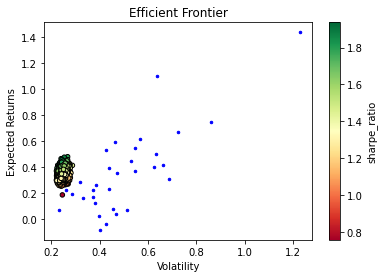

In [13]:
marks = ['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']


fig, ax = plt.subplots()
portf_results.plot(kind='scatter', 
                   x='volatility', 
                   y='returns', 
                   c='sharpe_ratio', 
                   cmap='RdYlGn', 
                   edgecolors='black', 
                   ax=ax)
ax.set(xlabel='Volatility', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_returns_ef, 'b--')
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]),
               y=avg_returns[asset_index],
               marker=marks[asset_index],
               s=25,
               color='blue',
               label=assets[asset_index])

In [14]:
max_sharpe_ind = np.argmax(portf_results.sharpe_ratio)
max_sharpe_portf = portf_results.loc[max_sharpe_ind]

min_vol_ind = np.argmin(portf_results.volatility)
min_vol_portf = portf_results.loc[min_vol_ind]

In [15]:
print ('Maximum Sharpe Ratio portfolio ----')
print ('Performance')
for index, value in max_sharpe_portf.items() :
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(assets,
weights[np.argmax(portf_results.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio ----
Performance
returns: 46.51% volatility: 24.01% sharpe_ratio: 193.66% 
Weights
AAF.L: 3.34% AEP.L: 2.51% AHT.L: 3.72% AVV.L: 1.65% BARC.L: 0.01% BEZ.L: 2.64% BIFF.L: 0.13% BLND.L: 0.30% BP.L: 0.22% CRDA.L: 6.56% CWR.L: 1.07% DPLM.L: 1.90% ENT.L: 3.65% FAN.L: 3.94% FUTR.L: 0.91% GSK.L: 6.78% GTLY.L: 1.72% INDV.L: 7.02% JD.L: 1.91% KAPE.L: 0.02% LUCE.L: 7.24% MGGT.L: 3.60% MMH.L: 6.55% NANO.L: 5.47% NFC.L: 1.33% PFD.L: 6.30% SAFE.L: 0.38% SCT.L: 3.78% SMT.L: 1.89% SPX.L: 2.69% WOSG.L: 5.64% XTR.L: 5.09% 

In [16]:
print ('Minimum Volatility portfolio ----')
print ('Performance')
for index, value in min_vol_portf.items() :
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(assets,
weights[np.argmin(portf_results.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio ----
Performance
returns: 29.96% volatility: 22.07% sharpe_ratio: 135.76% 
Weights
AAF.L: 2.22% AEP.L: 1.53% AHT.L: 0.21% AVV.L: 6.70% BARC.L: 7.58% BEZ.L: 7.94% BIFF.L: 0.71% BLND.L: 9.12% BP.L: 5.98% CRDA.L: 0.85% CWR.L: 0.82% DPLM.L: 4.93% ENT.L: 2.36% FAN.L: 2.31% FUTR.L: 0.11% GSK.L: 4.67% GTLY.L: 0.84% INDV.L: 0.74% JD.L: 1.53% KAPE.L: 0.10% LUCE.L: 1.00% MGGT.L: 5.75% MMH.L: 2.48% NANO.L: 0.67% NFC.L: 1.31% PFD.L: 0.42% SAFE.L: 7.52% SCT.L: 5.43% SMT.L: 4.59% SPX.L: 8.45% WOSG.L: 0.77% XTR.L: 0.36% 

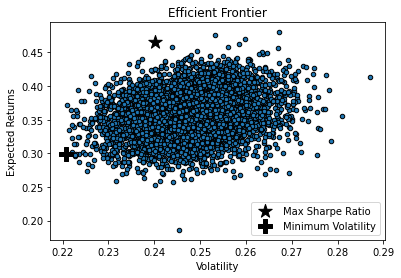

In [17]:
fig, ax = plt.subplots()
portf_results.plot(kind='scatter',
                   x='volatility',
                   y='returns',
                   cmap='RdYlGn',
                   edgecolors='black',
                   ax=ax)
ax.scatter(x=max_sharpe_portf.volatility,
           y=max_sharpe_portf.returns,
           c='black',
           marker='*',
           s=200,
           label='Max Sharpe Ratio')
ax.scatter(x=min_vol_portf.volatility,
           y=min_vol_portf.returns,
           c='black',
           marker='P',
           s=200,
           label='Minimum Volatility')
ax.set(xlabel='Volatility',
       ylabel='Expected Returns',
       title='Efficient Frontier')
ax.legend()

In [18]:
# Define functions for calculating portfolio return and volatility:

def get_portf_rtn(w, avg_rtns):
    return np.sum(avg_rtns * w)

def get_portf_vol(w, avg_rtns, cov_mat):
    return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

In [19]:
# Define the function calculating theEfficient Frontier:
def get_efficient_frontier(avg_rtns, cov_mat, rtns_range):
    efficient_portfolios = []
    n_assets = len(avg_returns)
    args = (avg_returns, cov_mat)
    bounds = tuple((0,1) for asset in range (n_assets))
    initial_guess = n_assets * [1. / n_assets, ]
    for ret in rtns_range:
        constraints = ({'type': 'eq',
                        'fun': lambda x: get_portf_rtn(x, avg_rtns) - ret},
                       {'type': 'eq',
                        'fun': lambda x: np.sum(x) - 1})
        efficient_portfolio = sco.minimize(get_portf_vol,
                                           initial_guess,
                                           args=args,
                                           method='SLSQP',
                                           constraints=constraints,
                                           bounds=bounds)
        efficient_portfolios.append(efficient_portfolio)
    return efficient_portfolios

In [20]:
# Define the considered range of returns
rtns_range = np.linspace (0.1, 0.32, 200)

In [21]:
# Calculate the Efficient Frontier
efficient_portfolios = get_efficient_frontier(avg_returns,
                                              cov_mat,
                                              rtns_range)

In [22]:
# Extract the volatilities of the efficient portfolios:
vols_range = [x['fun'] for x in efficient_portfolios]

[Text(0.5, 0, 'Volatility'),
 Text(0, 0.5, 'Expected Returns'),
 Text(0.5, 1.0, 'Efficient Frontier')]

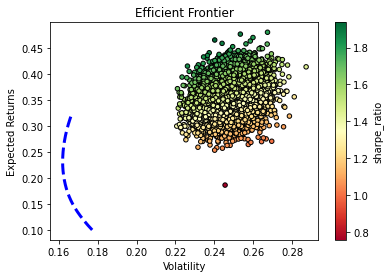

In [23]:
# Plot the calculated Efficient Frontier, together with the simulated portfolios:
fig, ax = plt.subplots()
portf_results.plot(kind='scatter',
                   x='volatility',
                   y='returns',
                   c='sharpe_ratio',
                   cmap='RdYlGn',
                   edgecolors='black',
                   ax=ax)
ax.plot(vols_range, rtns_range, 'b--', linewidth=3)
ax.set(xlabel='Volatility',
       ylabel='Expected Returns',
       title='Efficient Frontier')

In [24]:
# Identify the minimum volatility portfolio:
min_vol_ind = np.argmin(vols_range)
min_vol_portf_rtn = rtns_range[min_vol_ind]
min_vol_portf_vol = efficient_portfolios[min_vol_ind]['fun']

min_vol_portf = {'Return': min_vol_portf_rtn,
                 'Voltatility': min_vol_portf_rtn,
                 'Sharpe Ratio': (min_vol_portf_rtn /
                                  min_vol_portf_vol)}

In [25]:
# Print the performance summary:
print ('Minimum volatility portfolio ----')
print ('Performance')

for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
    
print('\nWeights')
for x, y in zip (assets,
efficient_portfolios[min_vol_ind]['x']):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum volatility portfolio ----
Performance
Return: 23.05% Voltatility: 23.05% Sharpe Ratio: 142.23% 
Weights
AAF.L: 0.00% AEP.L: 5.11% AHT.L: 0.00% AVV.L: 0.00% BARC.L: 0.00% BEZ.L: 0.00% BIFF.L: 5.36% BLND.L: 0.26% BP.L: 0.00% CRDA.L: 12.25% CWR.L: 0.00% DPLM.L: 0.00% ENT.L: 0.00% FAN.L: 5.53% FUTR.L: 0.00% GSK.L: 31.01% GTLY.L: 10.85% INDV.L: 0.00% JD.L: 0.00% KAPE.L: 0.00% LUCE.L: 0.00% MGGT.L: 0.00% MMH.L: 9.16% NANO.L: 0.67% NFC.L: 0.00% PFD.L: 4.39% SAFE.L: 6.59% SCT.L: 5.72% SMT.L: 0.00% SPX.L: 1.52% WOSG.L: 0.65% XTR.L: 0.91% 

In [26]:
# Define the objective function for the negative Sharpe Ratio:

def neg_sharpe_ratio(w, avg_rtns, cov_mat, rf_rate) :
    portf_returns = np.sum(avg_rtns * w)
    portf_volatility = np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))
    portf_sharpe_ratio = (portf_returns - rf_rate) / portf_volatility
    return -portf_sharpe_ratio

In [27]:
# Finding the optimized portfolio:
n_assets = len(avg_returns)
rf_rate = 0.01

args = (avg_returns, cov_mat, rf_rate)
constraints = ({'type': 'eq',
                'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0,1) for asset in range (n_assets))
initial_guess = n_assets * [1. / n_assets]

max_sharpe_portf = sco.minimize(neg_sharpe_ratio,
                                x0=initial_guess,
                                args=args,
                                method='SLSQP',
                                bounds=bounds,
                                constraints=constraints)

In [28]:
# Extracting information about the maximu Sharpe Ratio portfolio:
max_sharpe_portf_w = max_sharpe_portf['x']
max_sharpe_portf = {'Return': get_portf_rtn(max_sharpe_portf_w,
                                            avg_returns),
                    'Volatility': get_portf_vol(max_sharpe_portf_w, 
                                            avg_returns,
                                            cov_mat),
                    'Sharpe Ratio': -max_sharpe_portf['fun']}

In [29]:
# Printing performance summary:
print ('Maximum Sharpe Ratio portfolio ----')
print ('Performance')

for index, value in max_sharpe_portf.items():
    print(f'{index}: {100*value:.2f}% ', end="", flush=True)
    
print('\nWeights')
for x, y in zip (assets, max_sharpe_portf_w):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio ----
Performance
Return: 69.89% Volatility: 25.76% Sharpe Ratio: 267.46% 
Weights
AAF.L: 0.00% AEP.L: 0.00% AHT.L: 0.00% AVV.L: 0.00% BARC.L: 0.00% BEZ.L: 0.00% BIFF.L: 0.00% BLND.L: 0.00% BP.L: 0.00% CRDA.L: 8.09% CWR.L: 0.79% DPLM.L: 0.00% ENT.L: 0.00% FAN.L: 5.63% FUTR.L: 0.00% GSK.L: 0.00% GTLY.L: 0.00% INDV.L: 19.81% JD.L: 0.00% KAPE.L: 1.84% LUCE.L: 0.00% MGGT.L: 0.00% MMH.L: 21.67% NANO.L: 6.08% NFC.L: 6.89% PFD.L: 16.53% SAFE.L: 0.00% SCT.L: 0.00% SMT.L: 0.00% SPX.L: 0.00% WOSG.L: 5.88% XTR.L: 6.78% 

In [30]:
# Convert the annualised average returns and the covariance matrix to numpy arrays:
avg_returns = avg_returns.values
cov_mat = cov_mat.values

In [31]:
# Set up the optimization problem
weights = cp.Variable(n_assets)
gamma = cp.Parameter(nonneg=True)
portf_rtn_cvx = avg_returns @ weights
portf_vol_cvx = cp.quad_form(weights, cov_mat)
objective_function = cp.Maximize(portf_rtn_cvx - gamma * portf_vol_cvx)
problem = cp.Problem(objective_function,
                     [cp.sum(weights) == 1, weights>= 0])

In [32]:
# Calculate the Efficient Frontier
n_points = 25
portf_rtn_cvx_ef = np.zeros(n_points)
portf_vol_cvx_ef = np.zeros(n_points)
weights_ef = []
gamma_range = np.logspace(-3, 3, num=n_points)

for i in range (n_points) :
    gamma.value = gamma_range[i]
    problem.solve()
    portf_vol_cvx_ef[i] = cp.sqrt(portf_vol_cvx).value
    portf_rtn_cvx_ef[i] = portf_rtn_cvx.value
    weights_ef.append(weights.value)

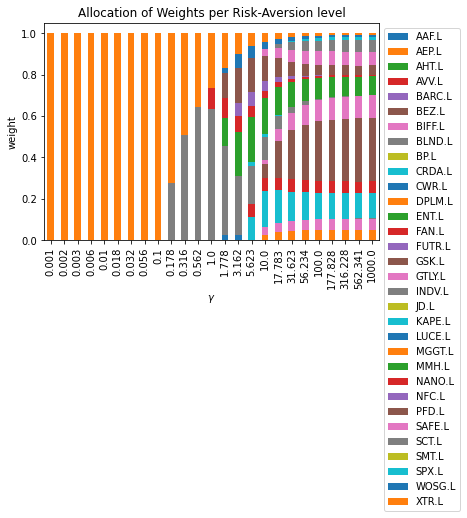

In [33]:
# Plot the allocation for different values of the risk-aversion parameter
weights_df = pd.DataFrame(weights_ef,
                          columns=assets,
                          index=np.round(gamma_range, 3))
ax = weights_df.plot(kind='bar', stacked=True)
ax.set(title='Allocation of Weights per Risk-Aversion level',
       xlabel=r'$\gamma$',
       ylabel='weight')
ax.legend(bbox_to_anchor=(1,1))

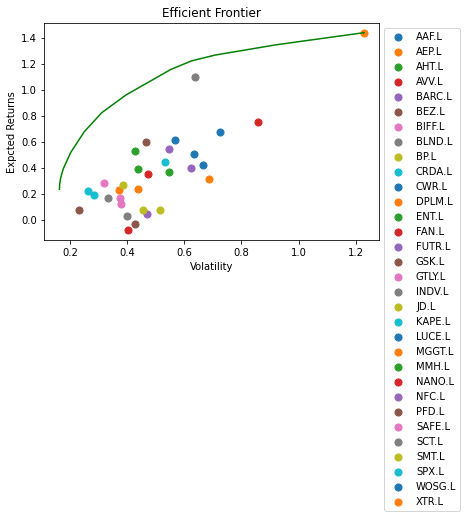

In [34]:
# Plotting the Efficient Frontier with individual assets
MARKS = ['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']
fig, ax = plt.subplots()
ax.plot(portf_vol_cvx_ef, portf_rtn_cvx_ef, 'g-')
for asset_index in range(n_assets):
     plt.scatter(x=np.sqrt(cov_mat[asset_index, asset_index]),
                 y=avg_returns[asset_index],
                 marker=MARKS[asset_index],
                 label=assets[asset_index],
                 s=200)
ax.set(title='Efficient Frontier',
       xlabel='Volatility',
       ylabel='Expcted Returns', )
ax.legend(bbox_to_anchor=(1,1))

[Text(0.5, 1.0, 'Maximized Risk-Adjusted Retrun'),
 Text(0.5, 0, 'Volatility'),
 Text(0, 0.5, 'Expected Returns'),
 (0.1, 0.5),
 (0.1, 2.0)]

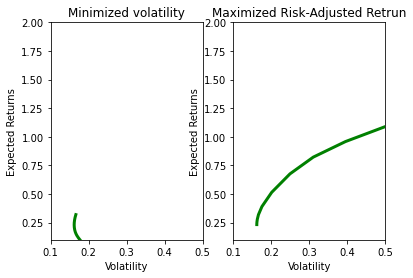

In [35]:
# Efficient frontier comparison
x_lim = [0.1, 0.5]
y_lim = [0.1, 2]

fig, ax = plt.subplots(1, 2)
ax[0].plot(vols_range, rtns_range, 'g-', linewidth=3)
ax[0].set(title='Minimized volatility',
          xlabel='Volatility',
          ylabel='Expected Returns',
          xlim=x_lim,
          ylim=y_lim)

ax[1].plot(portf_vol_cvx_ef, portf_rtn_cvx_ef, 'g-', linewidth=3)
ax[1].set(title='Maximized Risk-Adjusted Retrun',
          xlabel='Volatility',
          ylabel='Expected Returns',
          xlim=x_lim,
          ylim=y_lim)

In [36]:
# Analysing maximum allowable leverage
max_leverage= cp.Parameter()
problem_with_leverage = cp.Problem(objective_function,
                                   [cp.sum(weights) == 1,
                                    cp.norm(weights, 1) <= max_leverage])

In [37]:
# Redefining objects in order to store the results to be either larger 2D matrices or 3 = [1, 2, 5]
leverage_range = [1, 2, 5]
len_leverage = len(leverage_range)
n_points = 25

portf_vol_l_ef = np.zeros((n_points, len_leverage))
portf_rtn_l_ef = np.zeros((n_points, len_leverage))
weights_ef =np.zeros((len_leverage, n_points, n_assets))

for lev_ind, leverage in enumerate(leverage_range) :
    for gamma_ind in range(n_points):
        max_leverage.value = leverage
        gamma.value = gamma_range[gamma_ind]
        problem_with_leverage.solve(verbose=True)
        portf_vol_l_ef[gamma_ind, lev_ind] = cp.sqrt(portf_vol_cvx).value
        portf_rtn_l_ef[gamma_ind, lev_ind] = portf_rtn_cvx.value
        weights_ef[lev_ind, gamma_ind, :] = weights.value

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) May 12 06:18:47 AM: Your problem has 32 variables, 2 constraints, and 2 parameters.
(CVXPY) May 12 06:18:47 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 12 06:18:47 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 12 06:18:47 AM: Compiling problem (target solver=OSQP).
(CVXPY) May 12 06:18:47 AM: Reduction chain: FlipObjective -> CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) May 12 06:18:47 AM: Applying reduction FlipObjective
(CVXPY) May 12 06:18:47 AM: Applying reductio

C:\Users\Szenes Ibolya\anaconda3\envs\diss\lib\site-packages\cvxpy\problems\problem.py:1333: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


SolverError: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.

In [ ]:
# Efficient frontiers for dfferent maximum leverages
fig, ax=plt.subplots()

for leverage_index, leverage in enumerate(leverage_range):
    plt.plot(portf_vol_l_ef[:, leverage_index],
            portf_rtn_l_ef[:, leverage_index],
            label=f'{leverage}')
    
ax.set(title='efficient Frontier for different Maximum Leverages',
       xlabel='Volatility',
       ylabel='Expected Returns')
ax.legend(title='Max leverage',
          bbox_to_anchor=(1,1))

In [ ]:
# Plotting weight allocation per varying risk-aversion levels
fig, ax = plt.subplots(len_leverage, 1, sharex=True)

for ax_index in range(len_leverage):
    weights_df = pd.DataFrame (weights_ef[ax_index],
                               columns=assets,
                               index=np.round(gamma_range, 3))
    weights_df.plot(kind='bar',
                    stacked=True,
                    ax=ax[ax_index],
                    legend=None)
    ax[ax_index].set(ylabel=(f'max_leverage = {leverage_range[ax_index]}'
                             '/n weight'))
    
ax[len_leverage - 1].set(xlabel=r'$\gamma$')
ax[0].legend(bbox_to_anchor=(1,1))
ax[0].set_title('Weights allocation per risk-aversion level',
                fontsize=16)